# EDAN95 - Applied Machine Learning
### LTH Fall 2019

# Lab 5
### Jonas Lundgren

### GloVe embeddings

Code provided in lab instructions.

In [22]:
%matplotlib inline

from PIL import Image
import glob
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn import metrics

import matplotlib.pyplot as plt

In [23]:
# ---------------------------------------------------------------- #
# This code is mainly from the EDAN95 fall term lab session No 6,
# provided by Volker Krueger
# ---------------------------------------------------------------- #

class MNISTData :

    def __init__(self, dir):

        filelist = sorted(glob.glob(dir))
        self.x = np.array([np.array(Image.open(fname)) for fname in filelist])

        self.samples_per_class = 500
        self.number_of_classes = 10

        self.y = np.zeros(self.number_of_classes * self.samples_per_class,dtype=int)
        for cls in range(1,self.number_of_classes):
            self.y[(cls*500):(cls+1)*500] = cls


    def get_data(self):

        self.train_features, self.test_features, self.train_labels, self.test_labels = train_test_split(self.x, self.y, test_size=0.3,
                                                                                    random_state=42)
        self.train_normalised = self.train_features.reshape(3500, 400) / 255.0
        self.test_normalised = self.test_features.reshape(1500, 400) / 255.0

        return self.train_normalised, self.test_normalised, self.train_labels, self.test_labels


    def visualize_random(self):

        examples_per_class = 8
        for cls in range(self.number_of_classes):
            idxs = np.where(self.train_labels == cls)[0]
            idxs = np.random.choice(idxs, examples_per_class, replace=False)
            for i, idx in enumerate(idxs):
                plt.subplot(examples_per_class, self.number_of_classes, i * self.number_of_classes + cls + 1)
                plt.imshow(self.train_features[idx].astype('uint8'), cmap='gray')
                plt.axis('off')
                if i == 0:
                    plt.title(str(cls))
        plt.show()

    def visualize_wrong_class(self, pred, examples_per_class):
        for cls in range(self.number_of_classes):
            idxs = [idx for idx, value in enumerate(self.test_labels) if((value != cls) and (pred[idx] == cls))]
            if(len(idxs) > examples_per_class):
                idxs = np.random.choice(idxs, examples_per_class, replace=False)

            for i, idx in enumerate(idxs):
                plt.subplot(examples_per_class, self.number_of_classes, i * self.number_of_classes + cls + 1)
                plt.imshow(self.test_features[idx].astype('uint8'), cmap='gray')
                plt.axis('off')
                if i == 0:
                    plt.title(str(cls))
        plt.show()

## 1. Classifiers you should implement

### Provided Gaussian NB Classifier

Code provided from lab instructions.

In [40]:
from sklearn.naive_bayes import GaussianNB

In [41]:
def my_GaussianNB():
    mnist = MNISTData('Handout_NaiveBayes/MNIST_Light/*/*.png')


    train_features, test_features, train_labels, test_labels = mnist.get_data()

    mnist.visualize_random()

    gnb = GaussianNB()
    gnb.fit(train_features, train_labels)
    y_pred = gnb.predict(test_features)

    print("Classification report SKLearn GNB:\n%s\n"
      % (metrics.classification_report(test_labels, y_pred)))
    print("Confusion matrix SKLearn GNB:\n%s" % metrics.confusion_matrix(test_labels, y_pred))

    mnist.visualize_wrong_class(y_pred, 8)

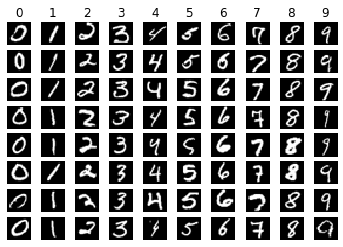

Classification report SKLearn GNB:
              precision    recall  f1-score   support

           0       0.54      0.94      0.69       164
           1       0.71      0.94      0.81       152
           2       0.83      0.50      0.62       155
           3       0.83      0.53      0.65       154
           4       0.75      0.31      0.44       143
           5       0.67      0.16      0.25       141
           6       0.81      0.85      0.83       143
           7       0.83      0.82      0.83       158
           8       0.41      0.64      0.50       132
           9       0.60      0.84      0.70       158

    accuracy                           0.66      1500
   macro avg       0.70      0.65      0.63      1500
weighted avg       0.70      0.66      0.64      1500


Confusion matrix SKLearn GNB:
[[154   0   6   0   1   1   0   0   1   1]
 [  1 143   1   0   0   1   0   1   3   2]
 [ 11   6  77  10   2   1  19   1  27   1]
 [ 32  11   5  82   0   0   2   3  12   7]
 [ 

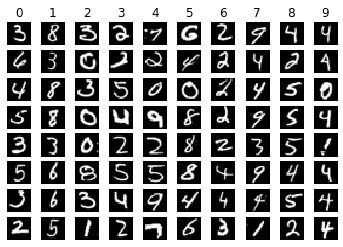

In [42]:
my_GaussianNB()

### Nearest Centroid Classifier (NCC)

In [43]:
from sklearn.neighbors import NearestCentroid

In [44]:
def my_NCC():
    mnist = MNISTData('Handout_NaiveBayes/MNIST_Light/*/*.png')


    train_features, test_features, train_labels, test_labels = mnist.get_data()

    mnist.visualize_random()

    ncc = NearestCentroid()
    ncc.fit(train_features, train_labels)
    y_pred = ncc.predict(test_features)

    print("Classification report SKLearn GNB:\n%s\n"
      % (metrics.classification_report(test_labels, y_pred)))
    print("Confusion matrix SKLearn GNB:\n%s" % metrics.confusion_matrix(test_labels, y_pred))

    mnist.visualize_wrong_class(y_pred, 8)

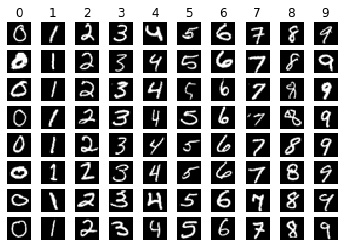

Classification report SKLearn GNB:
              precision    recall  f1-score   support

           0       0.91      0.91      0.91       164
           1       0.71      0.97      0.82       152
           2       0.84      0.73      0.78       155
           3       0.74      0.76      0.75       154
           4       0.75      0.76      0.75       143
           5       0.72      0.69      0.70       141
           6       0.90      0.86      0.88       143
           7       0.95      0.80      0.87       158
           8       0.79      0.72      0.75       132
           9       0.76      0.80      0.78       158

    accuracy                           0.80      1500
   macro avg       0.81      0.80      0.80      1500
weighted avg       0.81      0.80      0.80      1500


Confusion matrix SKLearn GNB:
[[150   0   2   0   0   6   3   1   2   0]
 [  0 148   0   0   0   2   0   0   2   0]
 [  0  15 113   8   2   3   3   1   8   2]
 [  1   5   8 117   1   7   1   2   8   4]
 [ 

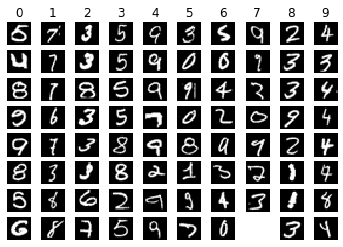

In [45]:
my_NCC()